## Loading Data

### Read Csv

In [1]:
import pandas as pd

df = pd.read_csv('../Datasets/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv', encoding='utf-8')

In [2]:
df.head(10)

,text,label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1
5,yeah retard haha,1
6,the ching chong chung stuff,1
7,the dead what a slut still warm when she tweet...,1
8,let your tweets be harmless it will not affect...,1
9,these latinos who have a problem with immigrat...,1


### Checking the data balance

In [3]:
df[df['label'] == 0].count()

text     361594
label    361594
dtype: int64

In [4]:
df[df['label'] == 1].count()

text     364525
label    364525
dtype: int64

<Axes: xlabel='label', ylabel='count'>

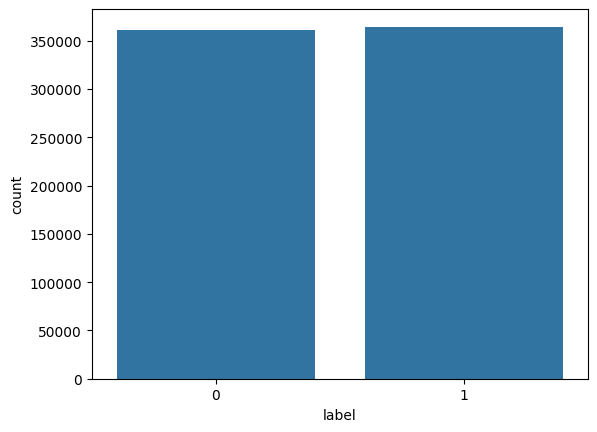

In [5]:
import seaborn as sns

sns.countplot(x='label', data=df)

### Downsample to balance the data

In [6]:
from sklearn.utils import resample
df0 = df[(df['label']==0)]
df1 = df[(df['label']==1)]

n = 64000

df0 = resample(df0,
              replace=True,
              n_samples= n,
              random_state=42)

df1 = resample(df1,
              replace=True,
              n_samples= n,
              random_state=42)

df = pd.concat([df0,df1], ignore_index=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128000 entries, 0 to 127999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    128000 non-null  object
 1   label   128000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


### Checking the data balance after downsample

<Axes: xlabel='label', ylabel='count'>

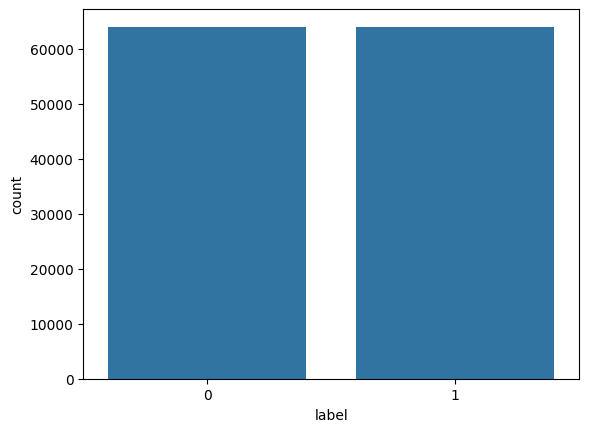

In [8]:
import seaborn as sns

sns.countplot(x='label', data=df)

## Preprocessing Data

### Create functions to process text data

In [9]:
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def lemmatize_words(tokenize_text):
   lemmatizer = WordNetLemmatizer()

   lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenize_text]

   return lemmatized_words

def stem_words(tokenized_text):
    stemmer = PorterStemmer()
    
    stemmed_words = [stemmer.stem(word) for word in tokenized_text]

    return stemmed_words

def remove_stopwords(tokenized_text):
    stop_words = set(stopwords.words('english'))
    
    filtered_words = [word for word in tokenized_text if word.lower() not in stop_words]

    return filtered_words

def remove_longwords(tokenized_text):
    filtered_words = [word for word in tokenized_text if len(word) <=45]

    return filtered_words
   

def remove_extra_spaces(text):
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()
  return text

def join_words(tokenized_text):
   return ' '.join(tokenized_text)

def tokenize_text(text):
   return word_tokenize(text)

In [10]:
def clean_text(text):
  # return join_words(stem_words(remove_stopwords(tokenize_text(text))))
  return join_words(lemmatize_words(remove_longwords(tokenize_text(text))))

### Applying text cleaner function

In [11]:
df['text'] = df['text'].apply(clean_text)
df.head(100)

,text,label
0,it is your translation that is where are you o...,0
1,you not be aware of this but a cocktail is cer...,0
2,well perhaps you could explain exactly what yo...,0
3,indexing by saddam or by hussein a recent edit...,0
4,a well a the role and the behavior of the invo...,0
...,...,...
95,she can not wear a bikini a she is chubby,0
96,harrison s flower le flour d harrison if one w...,0
97,yes indeed camel ostrich and zebra vccamelraces,0
98,your recent edits hello weinberg please do not...,0


### Deleting data that has string empty text

In [12]:
# len(df[df['text'].str.split().str.len() < 1])
# len(df[df['text'] == ''].values)
df = df[df['text'] != '']

### Creating wordcloud

In [13]:
# wc = ''

# for words in df['text'].values:
#   wc += ' '+words

# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# wordcloud = WordCloud(width = 800, height = 800,
#                 background_color ='white',
#                 min_font_size = 10).generate(wc)

# # plot the WordCloud image
# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad = 0)

# plt.show()

### Creating word index

In [14]:
import re

def generate_word_index(texts):
    word_index = {}
    index = 1  # Start indexing from 1, reserve index 0 for unknown words
    for text in texts:
        tokens = re.findall(r'\w+', text.lower())
        for token in tokens:
            if token not in word_index:
                word_index[token] = index
                index += 1
    return word_index

word_index = generate_word_index(df['text'].values)
len(word_index)

63977

### Calculating longest text by words

In [15]:
longest_text = 0
for text in df['text'].values:
  if len(text.split(' ')) > longest_text:
    longest_text = len(text.split(' '))

longest_text

310

### Tokenizing words based on created word index

In [16]:
df_ready_to_train = df.copy()
df_ready_to_train['text'] = df_ready_to_train['text'].apply(lambda text: [word_index.get(word, 0) for word in re.split(r'\W+', text.lower())])

In [17]:
import tensorflow as tf

df_ready_to_train['text'] = list(tf.keras.preprocessing.sequence.pad_sequences(df_ready_to_train['text'], maxlen=longest_text, padding='post'))

## Saving Data

In [18]:
SAVE_PATH = '../Datasets/processed-en-lemmatize-medium/'

### Creating Map

In [19]:
metadata = {}

### Saving general information

In [20]:
from datetime import datetime

metadata['name'] = 'optimalisasi-model-machine-learning-untuk-klasifikasi-ujaran-kebencian-pada-x-twitter'
metadata['author'] = 'doddy-s'
metadata['created_at'] = datetime.now().isoformat()
metadata['meta'] = {}

### Saving dataset metadata

In [21]:
dataset_file_name = 'english-hate-speech-processed-dataset'
dataset_file_format = 'csv'

metadata['meta']['dataset'] = {}
metadata['meta']['dataset']['longest_text'] = longest_text
metadata['meta']['dataset']['count'] = int(df['text'].count())
metadata['meta']['dataset']['file_name'] = dataset_file_name
metadata['meta']['dataset']['file_format'] = dataset_file_format

### Saving dataset-ready-to-train metadata

In [22]:
dataset_ready_to_train_file_name = 'english-hate-speech-processed-dataset-ready-to-train'
dataset_ready_to_train_file_format = 'parquet'

metadata['meta']['dataset_ready_to_train'] = {}
metadata['meta']['dataset_ready_to_train']['longest_text'] = longest_text
metadata['meta']['dataset_ready_to_train']['count'] = int(df_ready_to_train['text'].count())
metadata['meta']['dataset_ready_to_train']['file_name'] = dataset_ready_to_train_file_name
metadata['meta']['dataset_ready_to_train']['file_format'] = dataset_ready_to_train_file_format

### Saving word index metadata

In [23]:
word_index_file_name = 'english-hate-speech-processed-word-index'
word_index_file_format = 'json'

metadata['meta']['word_index'] = {}
metadata['meta']['word_index']['count'] = len(word_index)
metadata['meta']['word_index']['file_name'] = word_index_file_name
metadata['meta']['word_index']['file_format'] = word_index_file_format

### Exporting metadata to json file

In [24]:
import json

with open(SAVE_PATH+'metadata.json', 'w') as json_file:
  json.dump(metadata, json_file, indent=2)

### Exporting datasets

In [25]:
df.to_csv(SAVE_PATH+dataset_file_name+'.'+dataset_file_format, index=False, encoding='utf-8')
df_ready_to_train.to_parquet(SAVE_PATH+dataset_ready_to_train_file_name+'.'+dataset_ready_to_train_file_format)

with open(SAVE_PATH+word_index_file_name+'.'+word_index_file_format, 'w') as json_file:
  json.dump(word_index, json_file, indent=2)